In [1]:
!git clone https://github.com/jaydeep-work/LIME-SAM.git

Cloning into 'LIME-SAM'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 44 (delta 8), reused 27 (delta 2), pack-reused 0
Unpacking objects: 100% (44/44), 1.20 MiB | 3.06 MiB/s, done.


In [2]:
!pip install -r /content/LIME-SAM/requirement.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-apefl70r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-apefl70r
  Resolved https://github.com/facebookresearch/segment-anything.git to commit c1910835a32a05cbb79bdacbec8f25914a7e3a20
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 62.1 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-04-13 06:37:06--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.10, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   133MB/s    in 15s     

2023-04-13 06:37:22 (161 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [2]:
%cd /content/LIME-SAM

/content/LIME-SAM


In [3]:
import keras.utils as image
from keras.applications import inception_v3 as inc_net
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

import lime_image
import sam

In [4]:
# Initiate classification model =======================================================================
inet_model = inc_net.InceptionV3()

# Initiate SAM model ==================================================================================
sam.initiate_sam("/content/sam_vit_h_4b8939.pth", "vit_h")

96112376/96112376 [==============================] - 4s 0us/step


In [6]:
# Load image ====================================================================================================
img_path = "/content/LIME-SAM/cat_mouse.jpg"
img = image.load_img(img_path, target_size=(299, 299))
img = image.img_to_array(img)

segmentation_fn_img = img.copy()
print(segmentation_fn_img.shape)

img = np.expand_dims(img, axis=0)
img = inc_net.preprocess_input(img)
print(img.shape)

(299, 299, 3)
(1, 299, 299, 3)


In [7]:
# initiate LIME =================================================================================================
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000,
                                         segmentation_fn=sam.SAM_segmentation_fn,
                                         segmentation_fn_img=segmentation_fn_img)

(299, 299, 3)
(299, 299)
[ 0  1  2  3  4  5  6  7  8 11 12 13 14 16 17]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


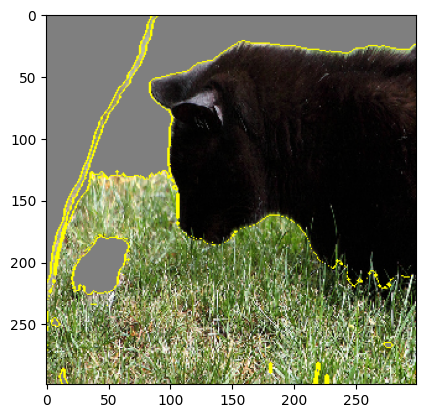

In [8]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

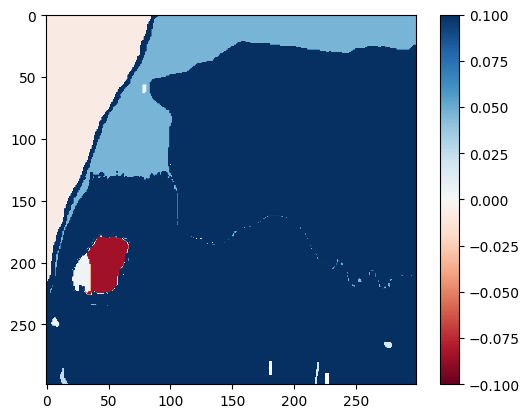

In [9]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.show()

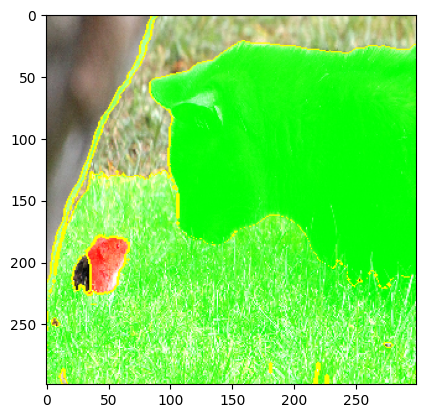

In [10]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))